In [2]:
from region_utils.shapes import Circle, ConvexPolygon
from region_utils.region import Domain, Subdomain
import jax.numpy as np
import numpy as onp
import json


#### Domain with matching dimensionality of problem in [DFG flow around cylinder benchmark 2D-1](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark1_re20.html) 

$$\omega =[0,2.2]×[0,0.41]∖B_r(0.2,0.2)$$
$$r = 0.05$$
Without subdomain decomposition (@JunmiaoHu)

In [3]:
#vertecies of domain in counter clockwise order
v1 = [0,0]
v2 = [2.2,0]
v3 = [2.2, 0.41]
v4 = [0, 0.41]

domain_points = np.asarray([v1, v2, v3, v4])
Cylinder = Circle(center=np.array([0.2, 0.2]), radius=0.05, has_boundary=True)
OuterRectangle = ConvexPolygon(domain_points, list(range(4)))

In [4]:
subdomain0 = Subdomain([OuterRectangle], [Cylinder])
domain = Domain([subdomain0])

In [5]:
domain.create_boundary(100)
domain.create_interior(500, [0, 0], [2.2, 0.41])

(494, 2)


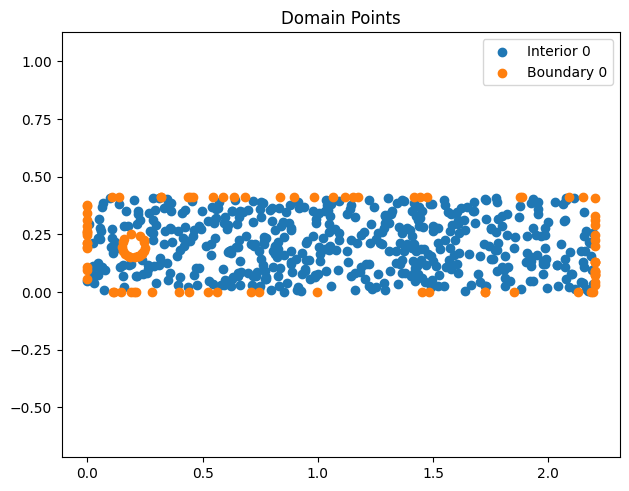

In [6]:
import matplotlib.pyplot as plt

plt.axis("equal")
# tight layout
plt.tight_layout()

domain.plot()

In [7]:
from utils import data_path

domain.write_to_file(data_path / "navier_stokes_pinn_train.json")

We need to add temporal dimention to data. As the code for generating 2d data is very
object oriented I suggest we do this manually with uglier ux

In [23]:
def add_temporal_dimension_training_data(input_file, t_max = 10, overwrite=False):
    str_rep = str(input_file)
    wo_suff = str_rep.removesuffix(".json")
    if overwrite:
        outfile = input_file
    else: 
        outfile = f"{wo_suff}_w_temporal.json"
    with open(input_file, "r") as infile:
        data = json.load(infile)
        for p in data['XPINNs']:
            for point in p['Internal points']:
                point.append(float(onp.random.uniform(0, t_max)))
            for point in p['Boundary points']:
                point.append(float(onp.random.uniform(0, t_max)))       
        for s in data['Interfaces']:
            for point in s['Points']:
                point.append(float(onp.random.uniform(0, t_max)))
                
    with open(outfile, "w") as outfile:
        json.dump(data, outfile)

Sanity check on XPINN_template

In [17]:
file = data_path / "XPINN_template.json"
add_temporal_dimension_training_data(file)

outfile = data_path / "XPINN_template_w_temporal.json"
with open(outfile, "r") as infile:
        data = json.load(infile)
        print(data)

{'XPINNs': [{'Internal points': [[0.5, 0.5, 0.1510090533356795], [0.7, 0.6, 3.2700366500425355], [0.8, 0.9, 1.8829003930624566]], 'Boundary points': [[0, 0, 1.0243859738812922], [1, 0, 3.6933527485926074], [0.5, 0, 4.743787524229265]]}, {'Internal points': [[0.5, 1.5, 1.1488776975053523], [0.7, 1.6, 2.969967209197634], [0.8, 1.9, 3.021629556116459]], 'Boundary points': [[1, 2, 0.7921934099544536], [1.5, 2, 1.0649199676129184], [0.5, 2, 1.201162701773404]]}], 'Interfaces': [{'XPINNs': [0, 1], 'Points': [[1, 1, 1.008311696490975], [0.2, 1, 2.258154172316655], [1.5, 1, 4.741167263372525]]}]}


In [18]:
file = data_path / "navier_stokes_pinn_train.json"
add_temporal_dimension_training_data(file, overwrite=True)

Let's attempt to sort the different boundaries

In [19]:
def sort_boundaries(input_file, overwrite=False):
    str_rep = str(input_file)
    wo_suff = str_rep.removesuffix(".json")
    if overwrite:
        outfile = input_file
    else:
        outfile = f"{wo_suff}_sorted.json"
    with open(input_file, "r") as infile:
        data = json.load(infile)
        #create buckets for the different boundaries
        left_boundary  = []
        top_and_bottom_boundary = []
        cylinder_boundary = []
        right_boundary = []
        for p in data['XPINNs']:
            for point in p['Boundary points']:
                if point[0] == 0:
                    left_boundary.append(point)
                    
                if point[0] == 2.2:
                    right_boundary.append(point)
                    
                elif point[1] == 0.41 or point[1] == 0:
                    top_and_bottom_boundary.append(point)
                    
                else:
                    cylinder_boundary.append(point)
            #now we combine the buckets and note the indecies of the different boundaries
            all_boundaries = left_boundary + top_and_bottom_boundary + cylinder_boundary + right_boundary
            left_boundary_index = len(left_boundary)
            top_and_bottom_boundary_index = len(left_boundary) + len(top_and_bottom_boundary)
            cylinder_boundary_index = len(left_boundary) + len(top_and_bottom_boundary) + len(cylinder_boundary)
            right_boundary_index = len(left_boundary) + len(top_and_bottom_boundary) + len(cylinder_boundary) + len(right_boundary)
            p['Boundary points'] = all_boundaries
            
            p['Boundary indices'] = {}
            p['Boundary indices']['left_boundary'] = left_boundary_index
            p['Boundary indices']['top_and_bottom_boundary'] = top_and_bottom_boundary_index
            p['Boundary indices']['cylinder_boundary'] = cylinder_boundary_index
            p['Boundary indices']['right_boundary'] = right_boundary_index
    
    with open(outfile, "w") as outfile:
        json.dump(data, outfile)

In [20]:
file = data_path / "navier_stokes_pinn_train.json"
sort_boundaries(file, overwrite=True)

Now let's handle the test data